In [25]:
import numpy as np
from scipy.integrate import quad
from scipy.special import beta
from scipy.spatial.distance import cdist, pdist
import matplotlib as mpl
from matplotlib import pyplot as plt

In [34]:
%matplotlib inline
mpl.rcParams['figure.dpi'] = 300

# Utility Functions

In [7]:
# Integral
def integral(f, l, u):
    return quad(f, l, u)[0]

integral(lambda x: x, 0, 1)

0.5

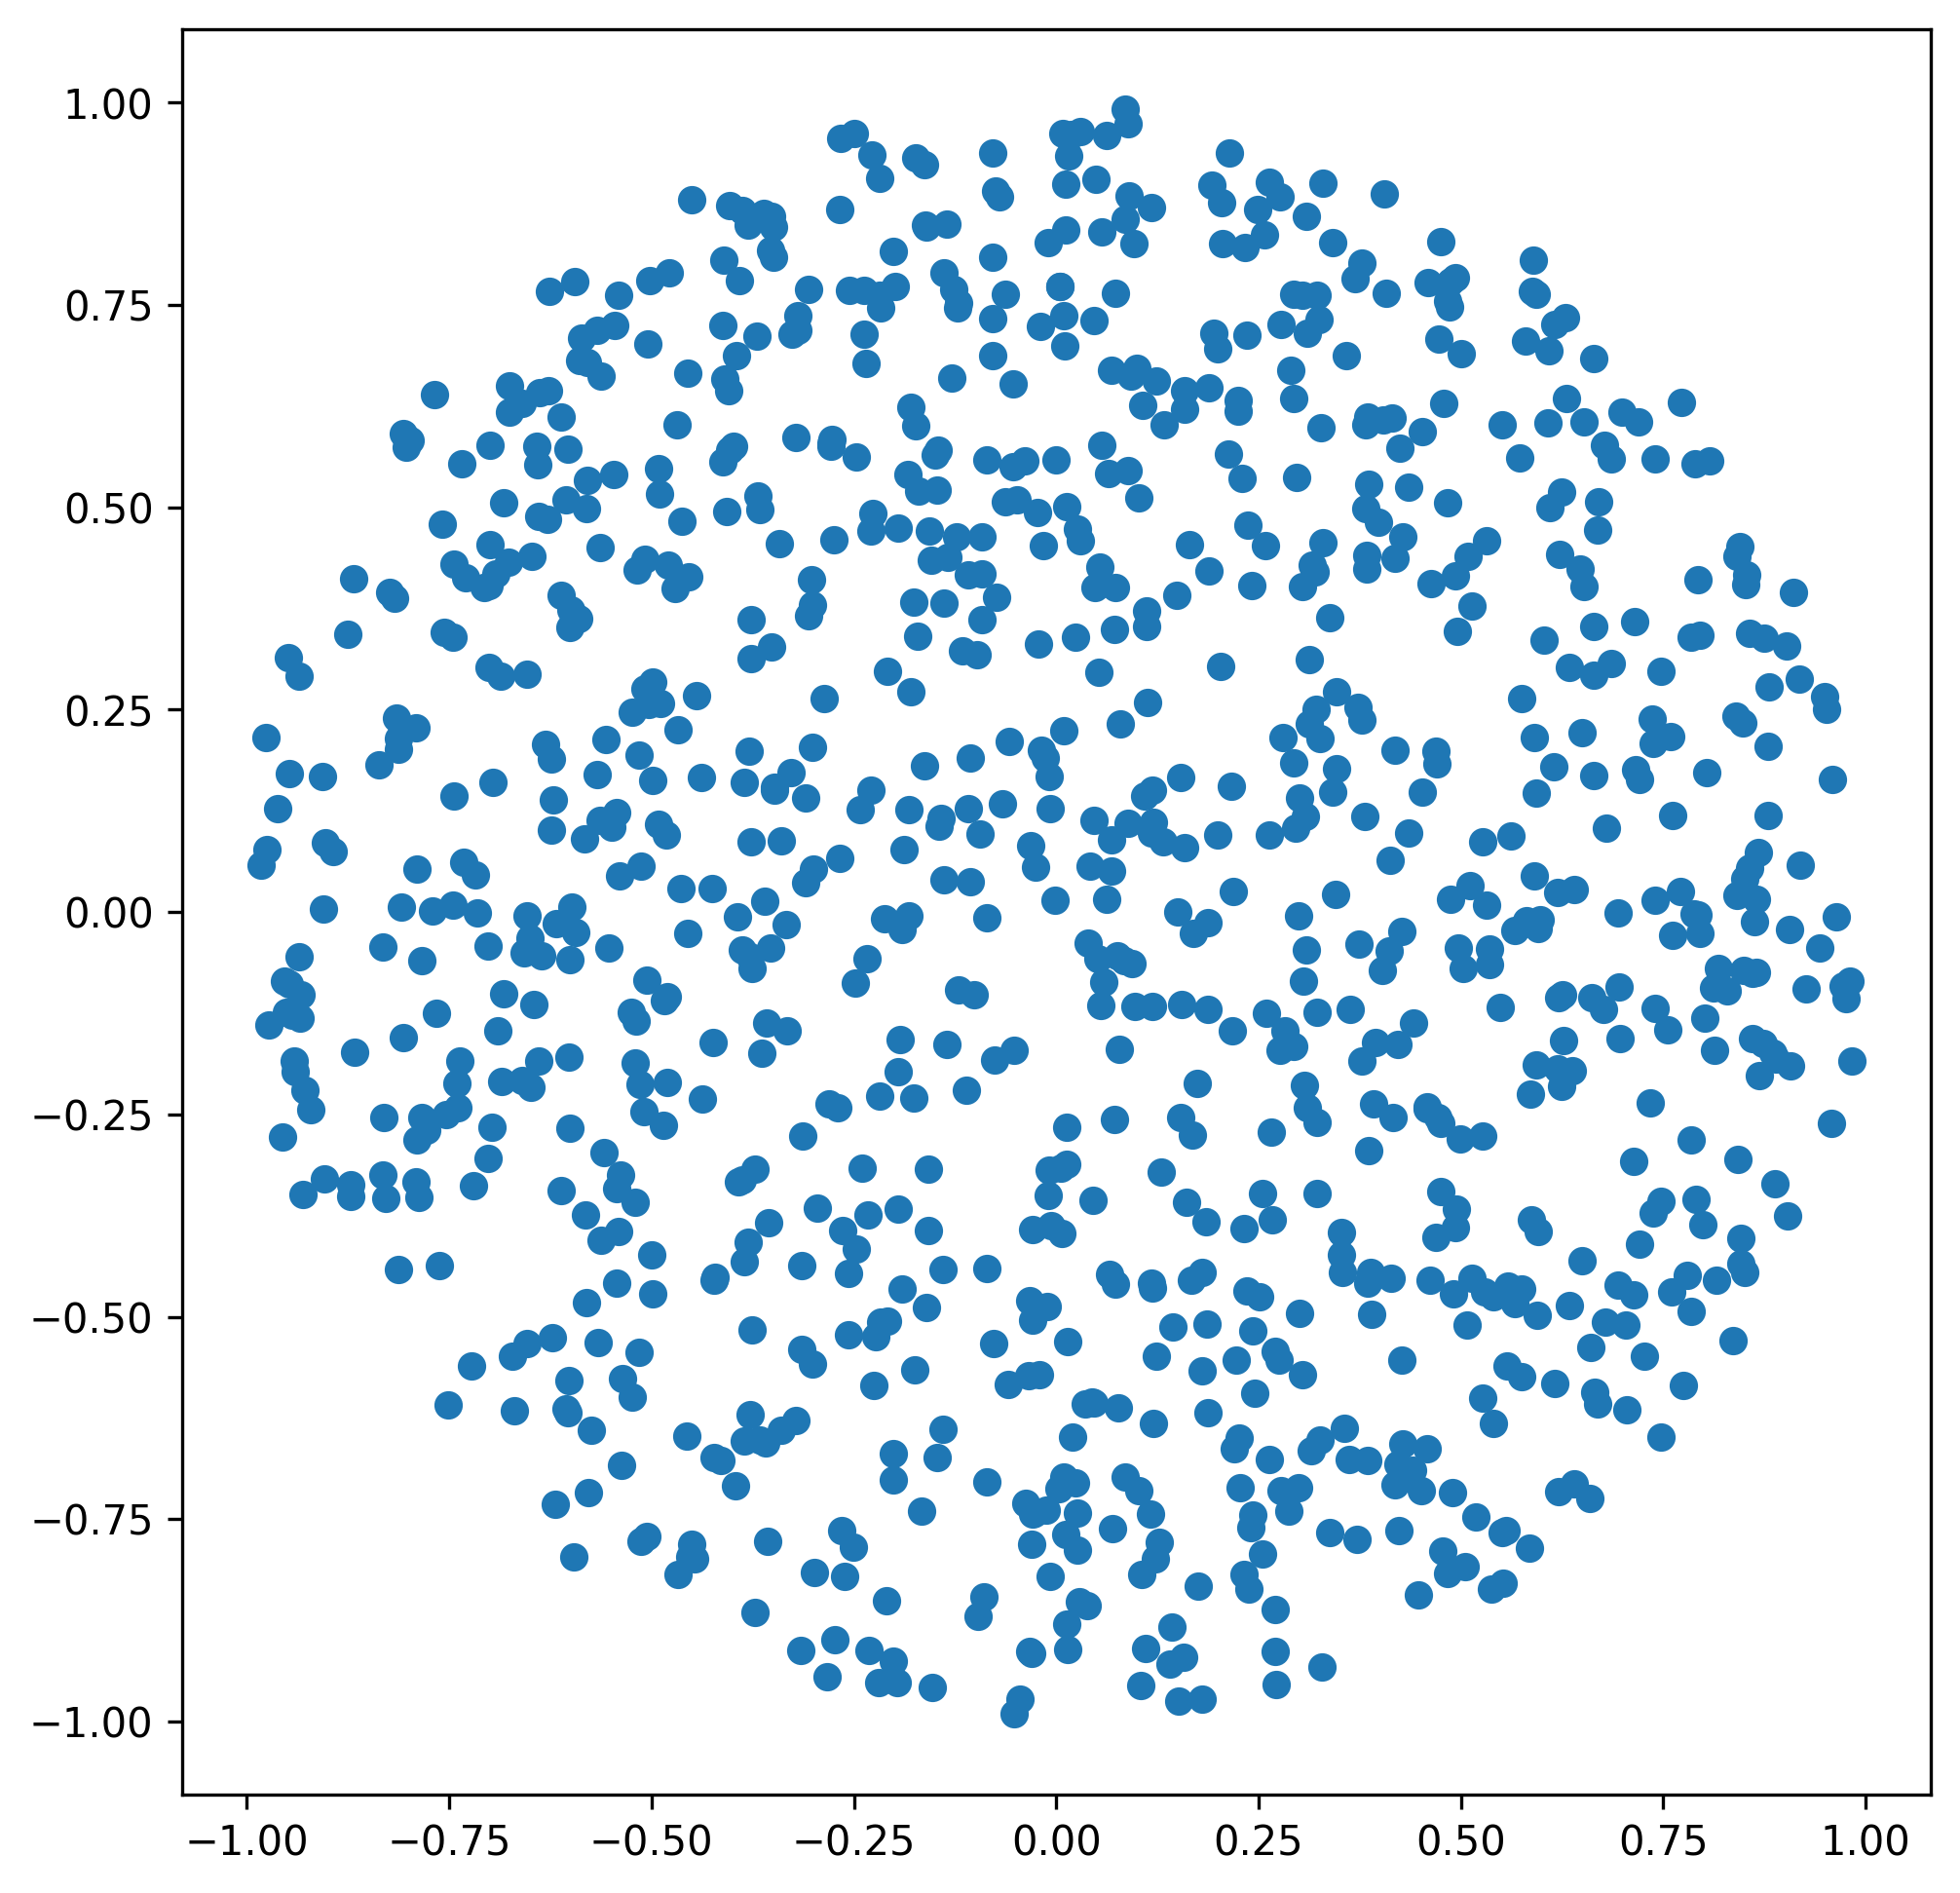

In [40]:
# Sampling inside a unit p-sphere
def sample_inside_unit_ball(p, N):
    '''
    Reference:
    https://math.stackexchange.com/questions/87230/picking-random-points-in-the-volume-of-sphere-with-uniform-probability
    '''
    X = np.random.normal(0, 1, (N, p))
    C = (np.random.uniform(0, 1, N) ** (1/p)) / np.linalg.norm(X, axis=1)
    return np.multiply(X, C[:, np.newaxis])

pts = sample_inside_unit_ball(2, 1000)
plt.figure(figsize=(8,8))
plt.gca().set_aspect('equal', adjustable='box')
plt.scatter(pts[:, 0], pts[:, 1])

# Random Distance Distribution inside Sphere Objects

## PDF and CDF

In [9]:
def g(y, p, r):
    '''
    Reference:
    https://arxiv.org/pdf/math-ph/0201046.pdf (eq. [20])
    '''
    num = (y ** (p-1)) * integral(lambda x: (r**2-x**2)**((p-1)/2), y / 2, 1)
    den = (1/(2*p)) * beta(p/2+1/2, 1/2) * r**(2*p)
    return num / den

def G(y, p, r):
    if y >= 2:
        return 1
    return integral(lambda _y: g(_y, p, r), 0, y)

## Verification

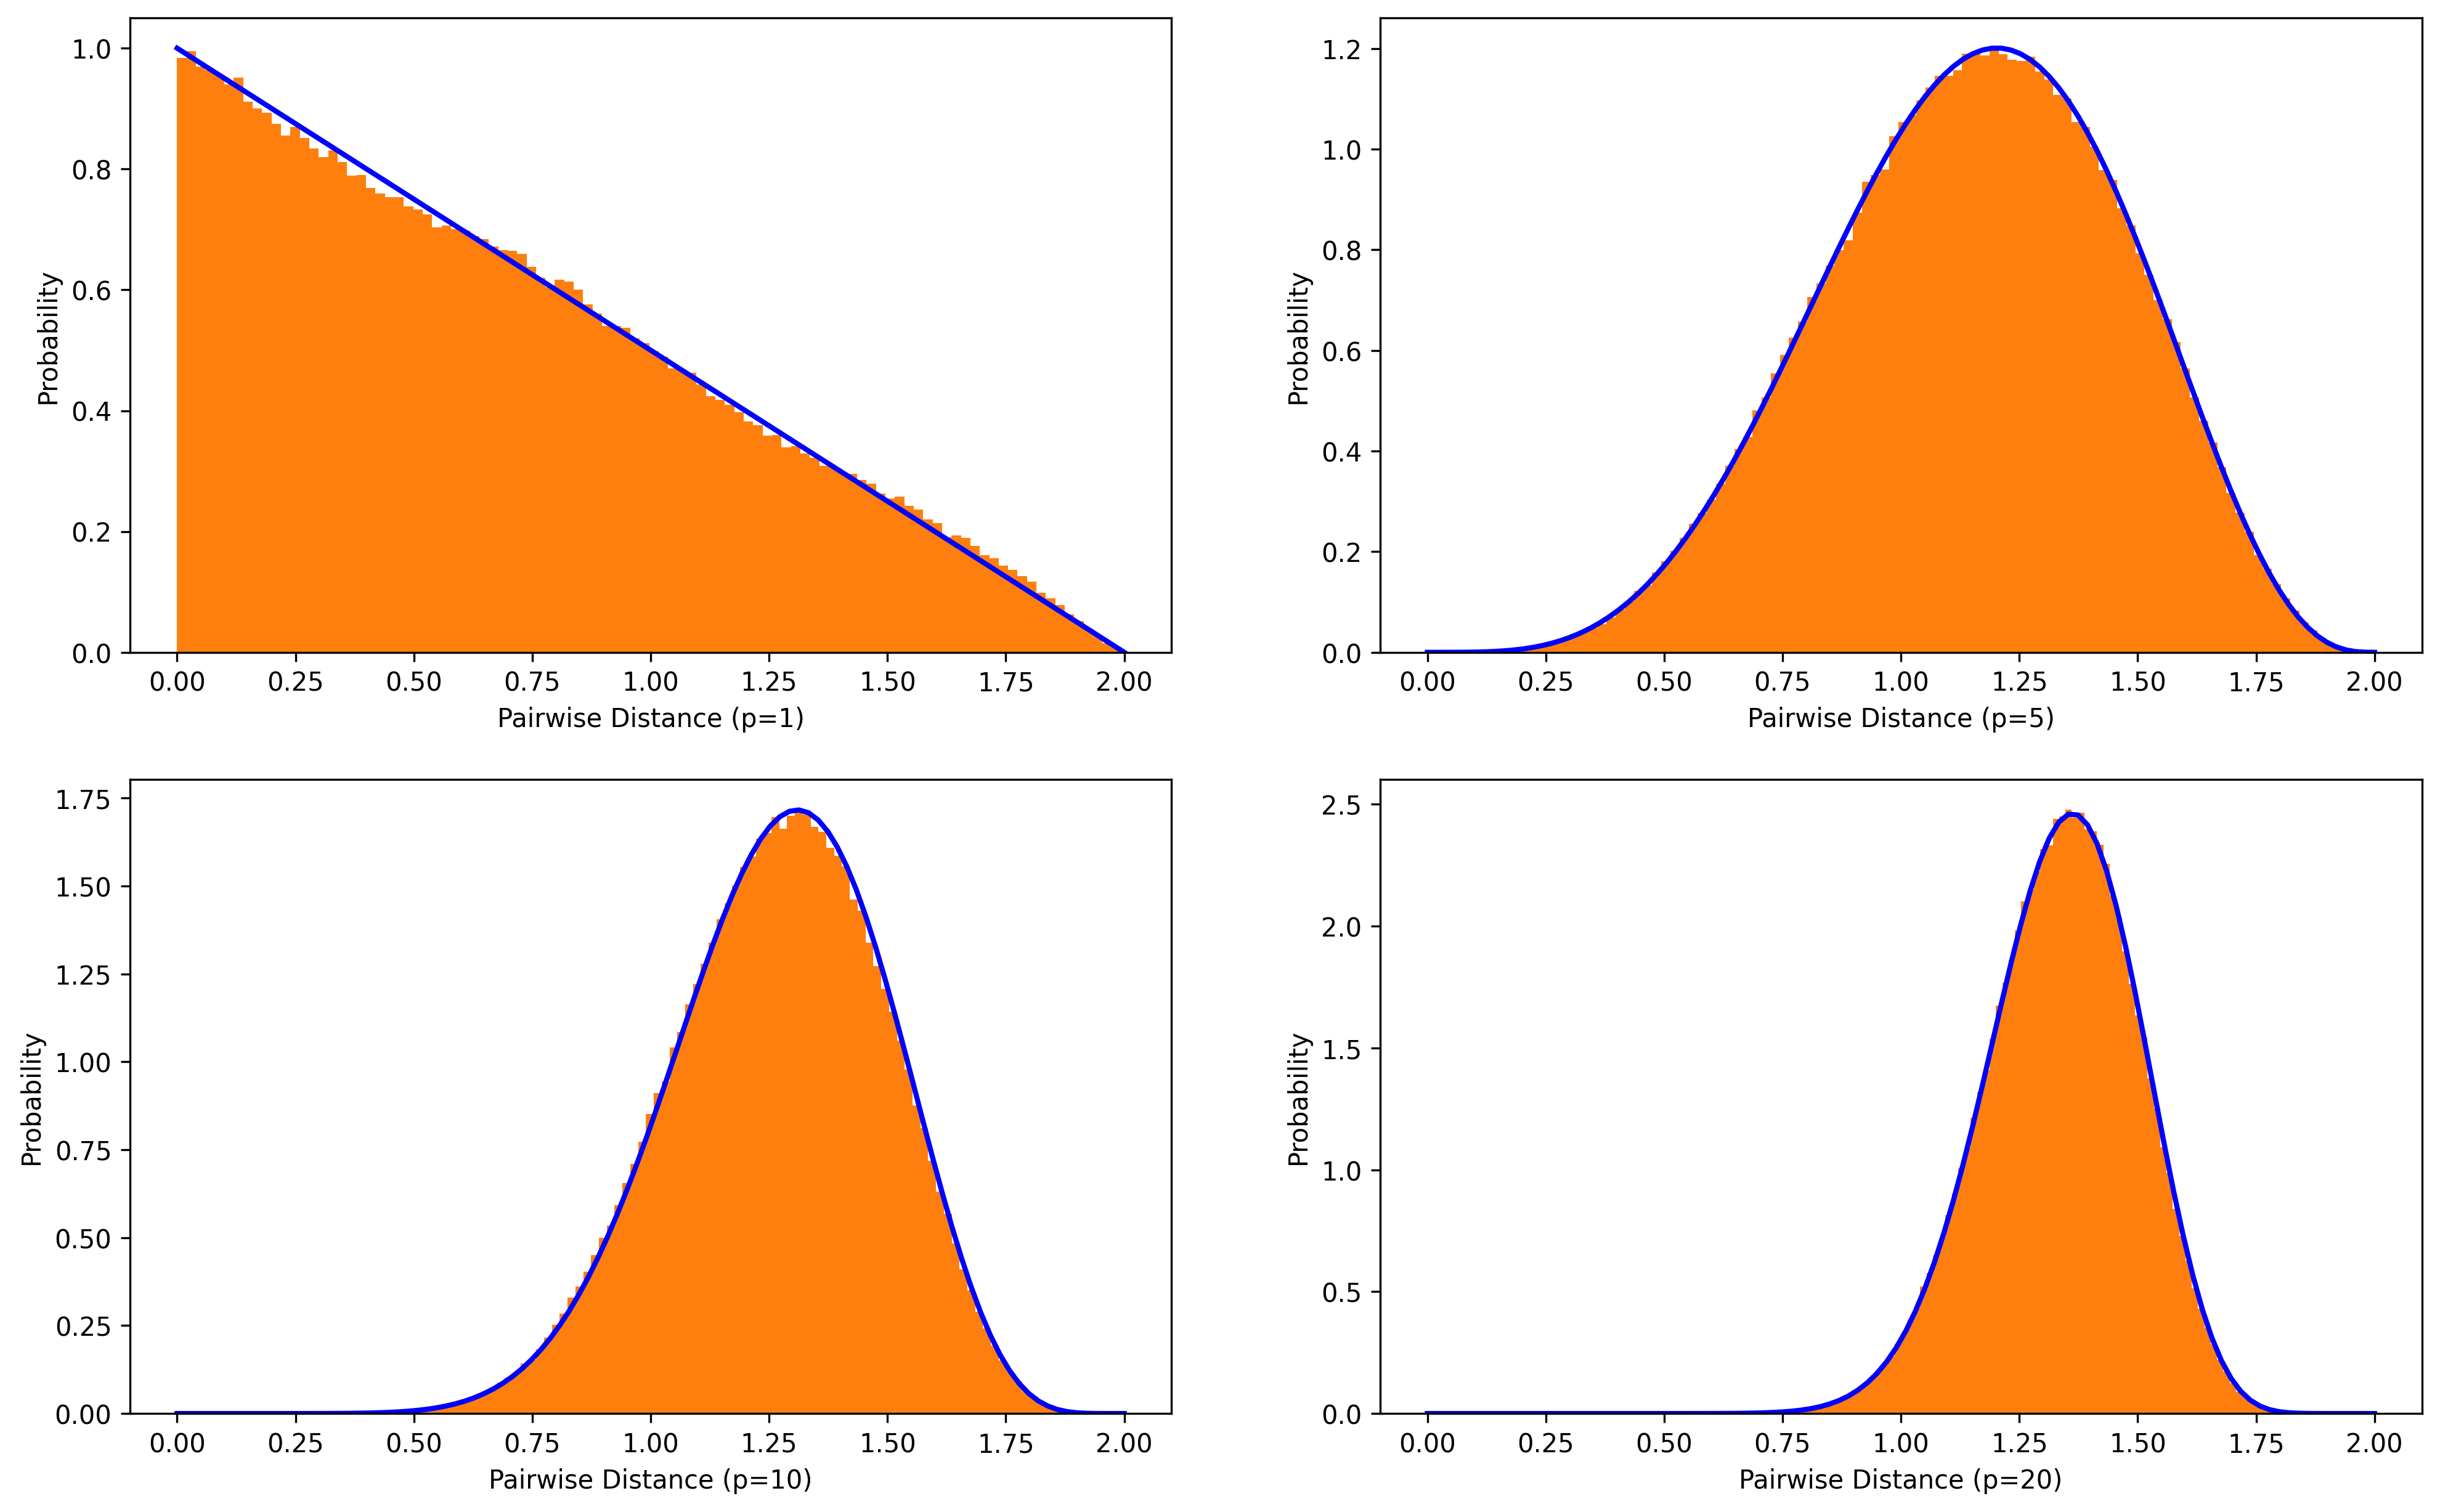

In [46]:
# The p's to be verified
test_p_s = [1, 5, 10, 20]

row = col = 2
fig, axs = plt.subplots(2, 2, figsize=(16, 10))

for r in range(row):
    for c in range(col):
        p = test_p_s[r * col + c]

        pts = sample_inside_unit_ball(p, 1000)
        
        dists = pdist(pts)
        axs[r, c].hist(dists, 100, density=True, facecolor='C1')
        
        y_s = np.linspace(0, 2, 100)
        axs[r, c].plot(y_s, [g(y, p, 1) for y in y_s], 'b', linewidth=2)

        axs[r, c].set_ylabel('Probability')
        axs[r, c].set_xlabel('Pairwise Distance (p=%s)' % test_p_s[r * col + c])

# Experiments

## Experiment Parameters

In [49]:
N_s = [10, 100, 1000, 10000]
p_s = range(1, 11)

## Theoretical Computing

In [50]:
def ThPr(p, N):
    f = lambda x: p * ((1-x)**(p-1))
    
    H = lambda y, r: (1 - G(y, p, r)) ** (N - 1)
    
    return integral(lambda x: H(x, 1) * f(x), 0, 1)

In [51]:
res_th = [[ThPr(p, N) for p in p_s] for N in N_s]
res_th

[[0.10526295712119653,
  0.49823913744137555,
  0.8016270110046906,
  0.9357548474347657,
  0.9814118582869211,
  0.9949567323499393,
  0.9986815672074776,
  0.9996627885017151,
  0.9999148887779061,
  0.9999786970131765],
 [0.010050251256281416,
  0.1714186371346879,
  0.4775713638234214,
  0.7437171814659648,
  0.8969129447516724,
  0.9643590962748223,
  0.988981013199086,
  0.9968538728559063,
  0.999149303642922,
  0.9997780712575604],
 [0.0010005002501250536,
  0.05547269371138724,
  0.24611179434962385,
  0.5078147864230256,
  0.7334136079263669,
  0.8773464758558598,
  0.9509109762008247,
  0.9825249633853601,
  0.9943514465624521,
  0.9983103365235871],
 [0.00010000500025001759,
  0.017666933929838164,
  0.11962522082529538,
  0.31757475462999957,
  0.547061611128349,
  0.740604175767388,
  0.8701682203421757,
  0.94242672882268,
  0.9770774210224806,
  0.9917005138308914]]

## Monte Carlo Simulation

In [52]:
SIM_SAMPLE_NUM = 200

def SimPr(p, N):
    count = 0
    for _ in range(SIM_SAMPLE_NUM):
        pts = sample_inside_unit_ball(p, N)
        
        first_pts = np.reshape(np.repeat(pts[0, :], N-1), (N-1, p))
        other_pts = pts[1:, :]
        
        min_pair_dist = np.min(np.linalg.norm(first_pts - other_pts, axis=1))
        dist_to_edge = 1 - np.linalg.norm(pts[0, :])
        
        if min_pair_dist > dist_to_edge:
            count += 1
    
    return count / SIM_SAMPLE_NUM
    

In [53]:
res_sim = [[SimPr(p, N) for p in p_s] for N in N_s]
res_sim

[[0.06, 0.525, 0.785, 0.895, 0.97, 0.985, 0.995, 1.0, 1.0, 1.0],
 [0.005, 0.2, 0.535, 0.75, 0.94, 0.95, 0.975, 1.0, 1.0, 1.0],
 [0.0, 0.065, 0.27, 0.535, 0.68, 0.88, 0.945, 0.97, 0.995, 1.0],
 [0.0, 0.02, 0.145, 0.375, 0.555, 0.74, 0.855, 0.91, 0.95, 0.995]]

## Results

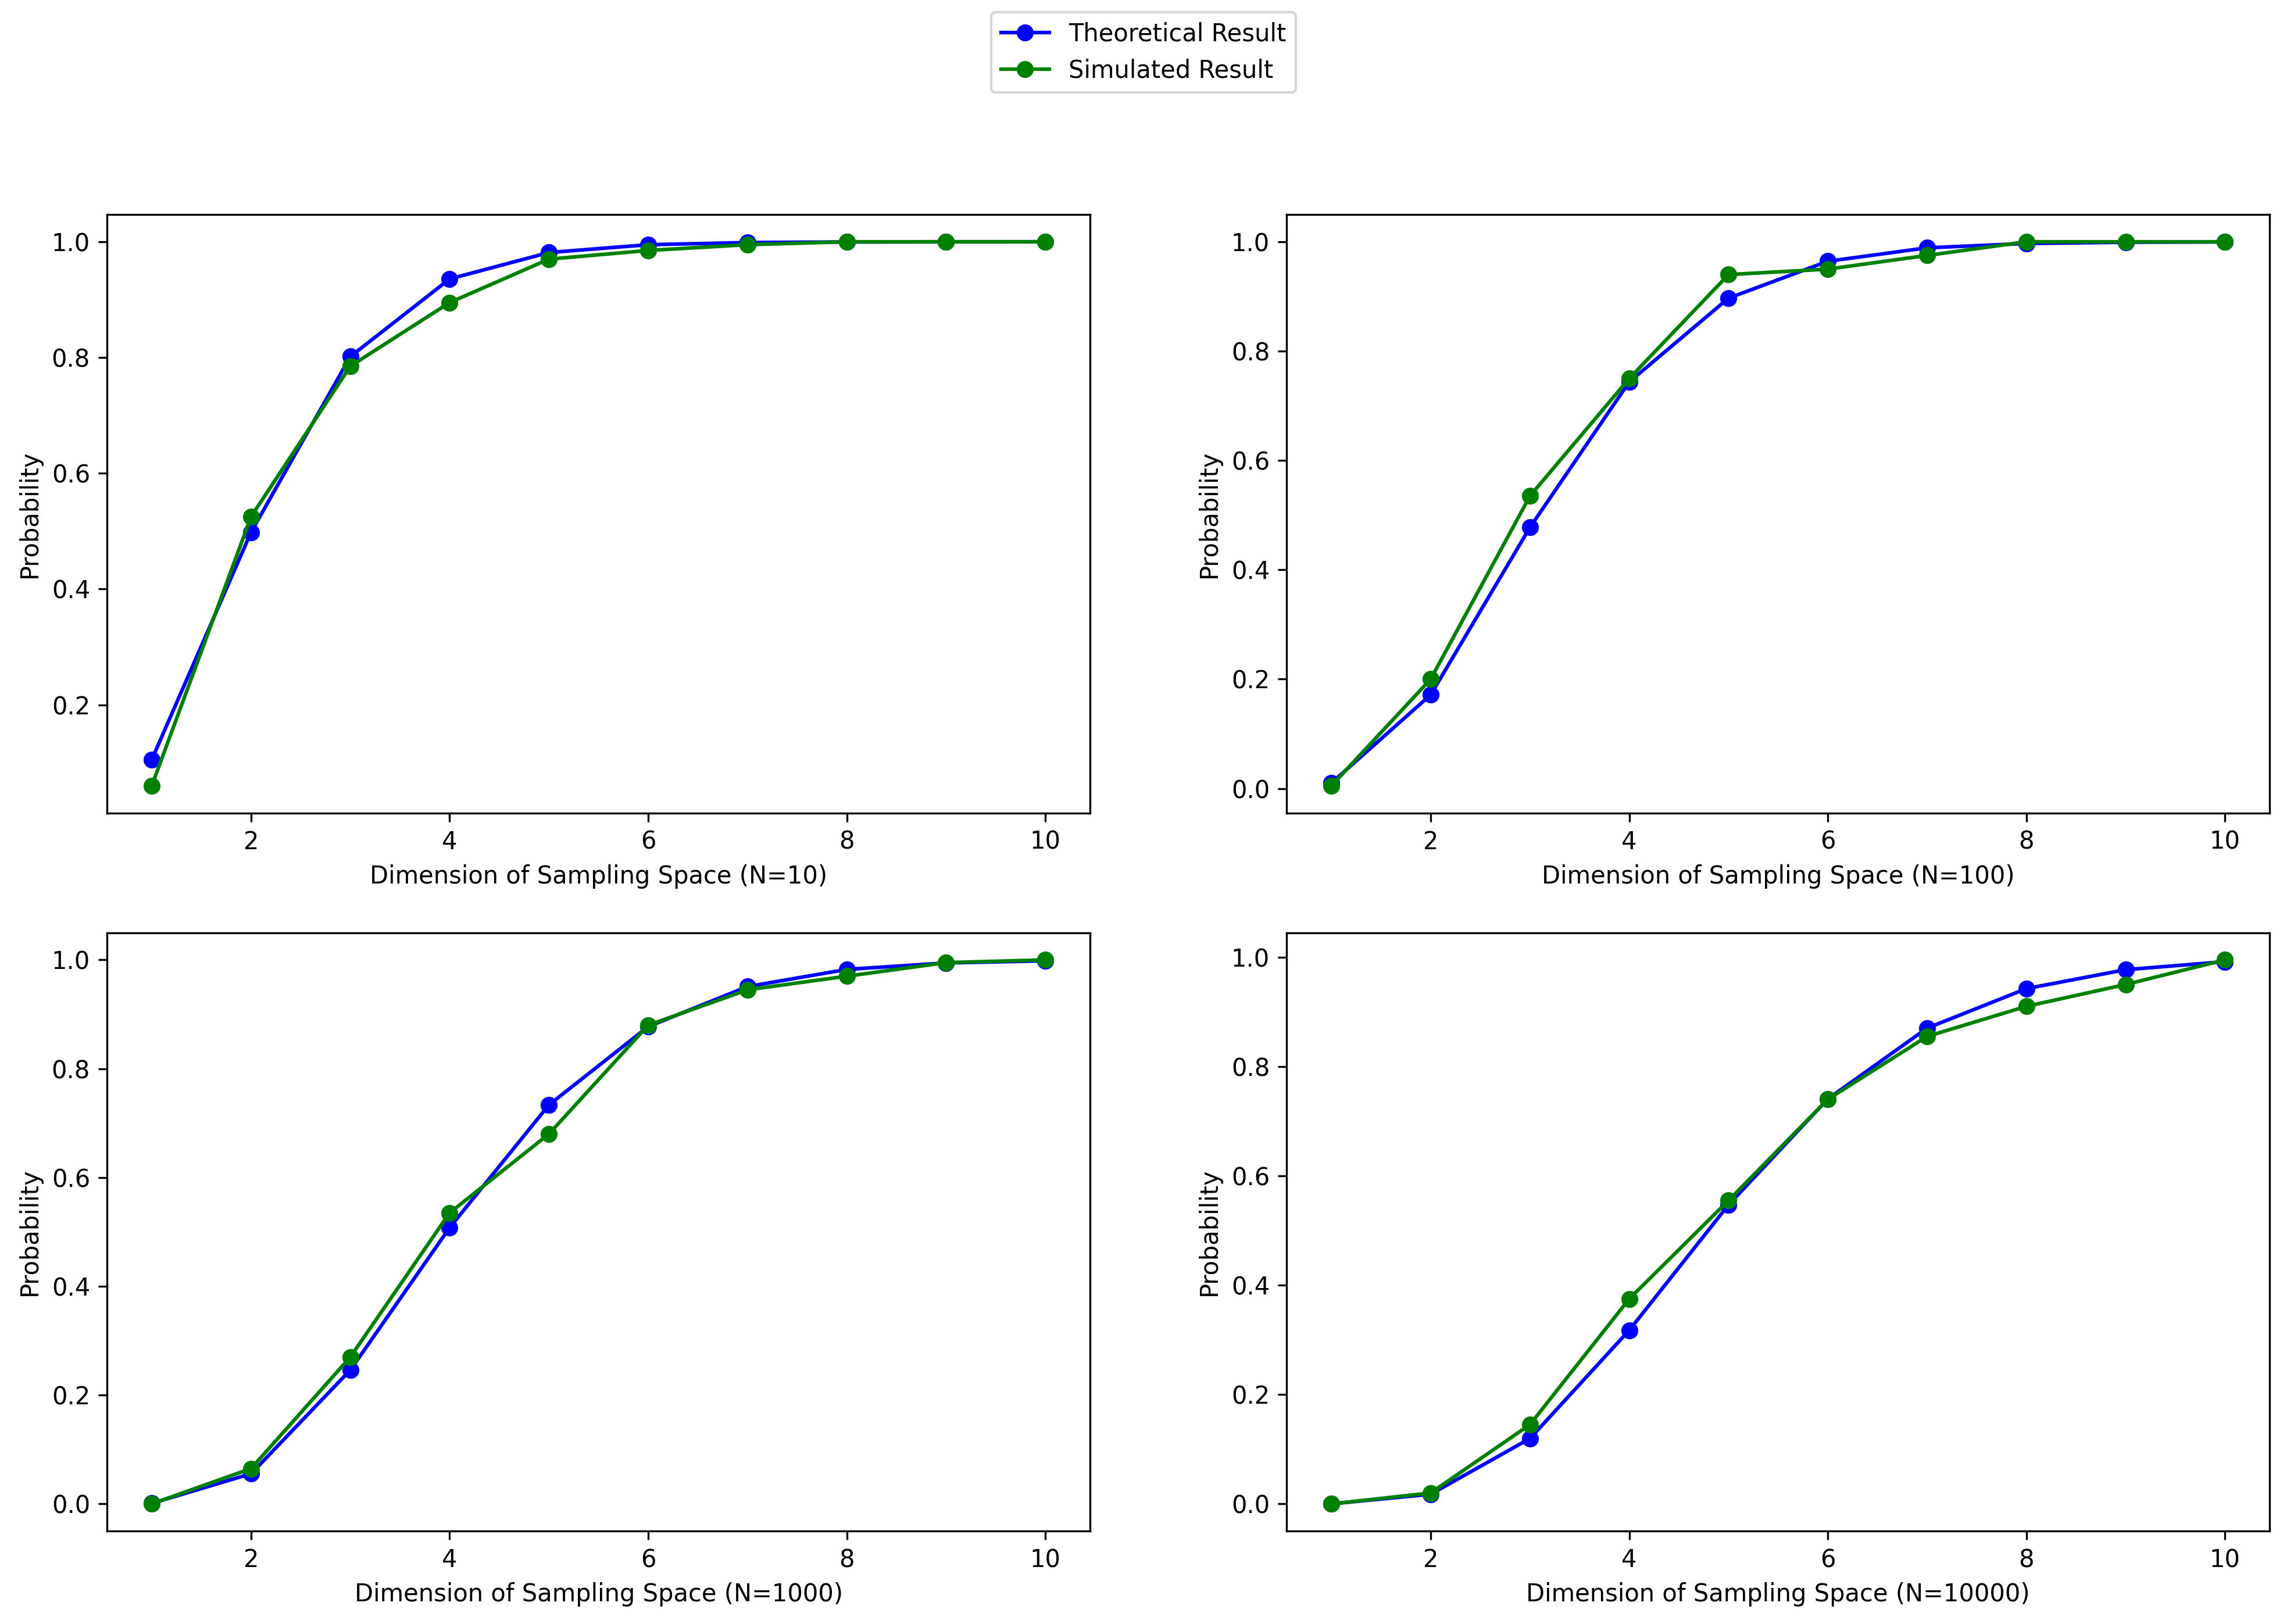

In [54]:
row = col = 2
fig, axs = plt.subplots(2, 2, figsize=(16, 10))

for r in range(row):
    for c in range(col):
        d_th = res_th[r * col + c]
        d_sim = res_sim[r * col + c]
        axs[r, c].plot([x for x in p_s], d_th, '-bo', label='Theoretical Result')
        axs[r, c].plot([x for x in p_s], d_sim, '-go', label='Simulated Result')
        axs[r, c].set_ylabel('Probability')
        axs[r, c].set_xlabel('Dimension of Sampling Space (N=%s)' % N_s[r * col + c])

handles, labels = axs[0, 0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center')